# Time Series Analysis of HiPSCats
Here we will use the lsdb framework to load ztf objects and sources then perform quick computations obtain some lightcurve information. 

### In this notebook we will...
* build off the joint catalog analysis as before
* analyze multiple hipscat catalogs through cross-matching
* join the resulting cross-match to source data (ztf_source)
* extract lightcurve information for our subset

In [1]:
import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=True, num_workers=8)

2023-11-05 08:20:45,405	WARNING services.py:1889 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67088384 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=5.63gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-11-05 08:20:46,573	INFO worker.py:1642 -- Started a local Ray instance.


#### Here we gather our datasets that have already been partitioned in the hipscat manner
\*we are aware that there is a bug in loading extremely large catalogs (ztf_source) and are working around on a fix

In [2]:
%%time
import lsdb
from hipscat.ADASS_Tutorial.credentials import read_storage_options

storage_options = read_storage_options()

gaia = lsdb.read_hipscat(
    "abfs:///hipscat/catalogs/gaia_dr3", 
    storage_options=storage_options, 
    columns=['ra', 'dec', 'pmra', 'pmdec']
)
ztf = lsdb.read_hipscat(
    "abfs:///hipscat/catalogs/ztf_dr14",
    storage_options=storage_options,
    columns=['ra', 'dec', 'ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i']
)
ztf_sources = lsdb.read_hipscat(
    "abfs:///hipscat/catalogs/ztf_source", 
    storage_options=storage_options,
    columns = ['ra', 'dec', 'ps1_objid', 'band', 'mjd', 'mag', 'magerr']
)

CPU times: user 24.6 s, sys: 4.68 s, total: 29.3 s
Wall time: 43.5 s


#### Cull the gaia through conesearch, cross_match with gaia, and then perform a cut on density of observation

In [3]:
%%time
import numpy as np
ztf_sample = gaia.cone_search(
    ra=31,
    dec=30,
    radius=1,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 20 and nobs_r_ztf_dr14 > 20 and nobs_i_ztf_dr14 > 20"
).assign(
    g_minus_r=lambda x: x["mean_mag_g_ztf_dr14"]-x["mean_mag_r_ztf_dr14"],
    r_minus_i=lambda x: x["mean_mag_r_ztf_dr14"]-x["mean_mag_i_ztf_dr14"]
).compute()

CPU times: user 411 ms, sys: 108 ms, total: 520 ms
Wall time: 23.5 s


In [4]:
ztf_sample

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST,g_minus_r,r_minus_i
_hipscat_index,,,,,,,,,,,,,,,,
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,17.355165,16.185900,15.758949,0.000008,1.169265,0.426951
599522540544589824,31.429665,29.079871,4.824305,-15.137056,31.429661,29.079877,142890314296516472,467,610,45,18.527807,17.132010,16.466106,0.000007,1.395797,0.665904
599522768177856512,31.406200,29.082557,-1.012378,-3.243405,31.406189,29.082573,142890314062089682,478,613,46,14.323063,13.455056,13.143231,0.000019,0.868007,0.311826
599522841192300544,31.462827,29.086511,0.567992,-0.572760,31.462810,29.086524,142900314628284417,340,476,35,20.244104,19.883095,19.806608,0.000020,0.361009,0.076487
599522849782235136,31.463904,29.089568,3.515846,-4.241290,31.463900,29.089582,142900314638728086,473,605,43,18.525228,18.328787,18.316226,0.000015,0.196440,0.012561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602924150348054528,30.358062,30.828354,18.293109,1.556143,30.358076,30.828373,144990303580194520,468,716,47,19.302731,17.829468,16.789261,0.000023,1.473263,1.040206
602924171822891008,30.348836,30.818440,15.094414,-5.270110,30.348845,30.818461,144980303488052646,491,648,56,15.464070,14.815594,14.562860,0.000023,0.648476,0.252734
602924171822891009,30.361674,30.824070,15.220351,-12.681022,30.361684,30.824079,144980303616449402,499,721,48,17.585441,16.964811,16.788843,0.000012,0.620630,0.175968


#### Object science: Color-Color diagrams
We calculated colors on from average magnitude values, lets see what they look like.

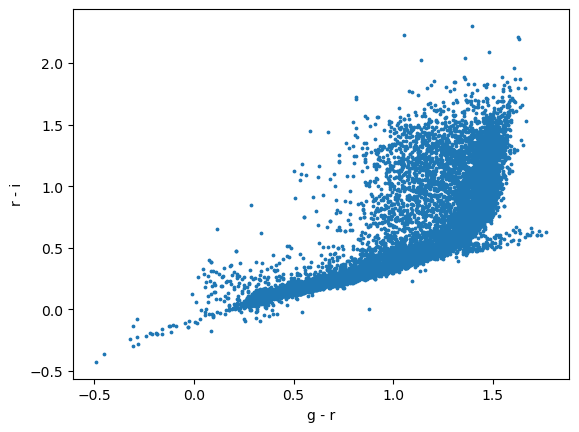

In [5]:
import matplotlib.pyplot as plt
ax = plt.subplot()
im = ax.scatter(
    ztf_sample["g_minus_r"],
    ztf_sample["r_minus_i"],
    s=3,
)
ax.set_xlabel("g - r")
ax.set_ylabel("r - i")
plt.show()

#### Since we still want to perform a join on sources to obtain lightcurve information, we have to re-hipscat it at a high-order.
There is a slight art to this to minimize the number of files we want to join to.

In [6]:
type(ztf_sample)

pandas.core.frame.DataFrame

In [7]:
%%time
ztf_sample_re_hips = lsdb.from_dataframe(
    ztf_sample, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia"
)
print(type(ztf_sample))

<class 'pandas.core.frame.DataFrame'>
CPU times: user 554 ms, sys: 5.77 ms, total: 560 ms
Wall time: 554 ms


#### Next, join with ztf sources on their ps1_objectid

In [8]:
%%time
ztf_sample_with_sources = ztf_sample_re_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
).compute()

CPU times: user 8.46 s, sys: 1.25 s, total: 9.71 s
Wall time: 1min 23s


In [9]:
print(type(ztf_sample_with_sources))
ztf_sample_with_sources

<class 'pandas.core.frame.DataFrame'>


,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,...,_DIST,g_minus_r,r_minus_i,ra,dec,ps1_objid,band,mjd,mag,magerr
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0.000008,1.169265,0.426951,31.427433,29.079234,142890314274265699,g,59268.15442,17.314888,0.018315
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0.000008,1.169265,0.426951,31.427433,29.079234,142890314274265699,g,59168.22101,17.350910,0.018652
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0.000008,1.169265,0.426951,31.427433,29.079234,142890314274265699,g,59170.22956,17.379185,0.018924
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0.000008,1.169265,0.426951,31.427433,29.079234,142890314274265699,g,59164.35017,17.377768,0.018910
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0.000008,1.169265,0.426951,31.427433,29.079234,142890314274265699,g,59172.24582,17.365601,0.018792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0.000041,1.134904,0.673440,30.387044,30.844180,145010303870113490,r,58425.28034,20.407598,0.153102
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0.000041,1.134904,0.673440,30.387044,30.844180,145010303870113490,r,58349.47579,20.401468,0.152558
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0.000041,1.134904,0.673440,30.387044,30.844180,145010303870113490,r,58426.27688,20.486242,0.152677


#### Performing time-series analysis of one object

In [10]:
one_object = ztf_sample_with_sources.query("_hipscat_index == 599522536249622528")
one_object_gband = one_object.query("band == \"g\"")
one_object_rband = one_object.query("band == \"r\"")
one_object_iband = one_object.query("band == \"i\"")

gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]

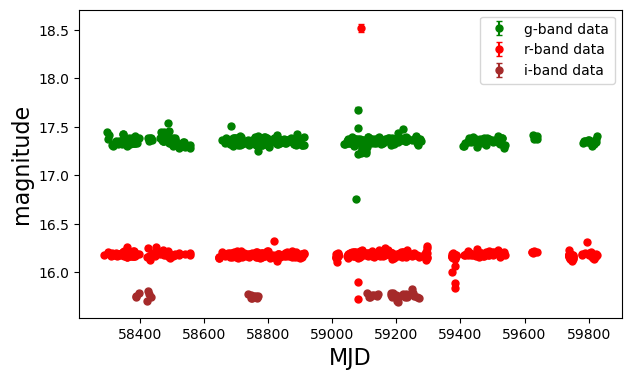

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.errorbar(gband_mjd, gband_mag, yerr=gband_magerr,\
             c="green", label = 'g-band data', ls='', marker='.', ms=10, capsize=2)
plt.errorbar(rband_mjd, rband_mag, yerr=rband_magerr,\
             c="red", label = 'r-band data', ls='', marker='.', ms=10, capsize=2)
plt.errorbar(iband_mjd, iband_mag, yerr=iband_magerr,\
             c="brown", label = 'i-band data', ls='', marker='.', ms=10, capsize=2)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.legend()

#### Time Series analysis of many objects

First we will re-use our trick of "re-hipscatting" our result
* this will allow us to use our `lsdb.Catalog.for_each` method, which is essentially is a `groupby().apply()` that doesn't rely on shuffling because we know all of our groups are already within our lsdb partitions
* define our variability analysis function
* * astropy.timeseries.LobScargle lightcurve frequency estimation
* perform the computation with `lsdb.Catalog.for_each`

In [12]:
%%time
ztf_sample_with_sources_rehips = lsdb.from_dataframe(
    ztf_sample_with_sources, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia",
    threshold=1_000_000
)
print(type(ztf_sample_with_sources_rehips))

<class 'lsdb.catalog.catalog.Catalog'>
CPU times: user 4.84 s, sys: 3.41 ms, total: 4.84 s
Wall time: 4.94 s


#### Our lightcurve analysis function
Here we perform LombScargle frequency estimation on the r-band light curve
We return:
* the evaluated frequency
* its respective "power"
* the false-alarm probability
* and the ligthcurve standard deviation

In [13]:
from astropy.timeseries import LombScargle as ls
import pandas as pd
import numpy as np

def lightcurve_variability_analysis(df):
    df_rband = df.query("band == \"r\"")

    r_ls = ls(df_rband["mjd"], df_rband["mag"], df_rband["magerr"])
    r_freq, r_power = r_ls.autopower()


    return pd.DataFrame(
        {
            "ps1_objid" : [df["ps1_objid"].values.tolist()[0]],
            "r_best_freq" : [r_freq[np.argmax(r_power)]],
            "r_best_power" : [r_power.max()],
            "r_far" : [r_ls.false_alarm_probability(r_power.max())],
            "r_mag_std" : [np.std(df_rband["mag"])]
        }
    )

#### Performing the distributed analysis.

Note:
* Distributed `groupby().apply()` methods require the partitions to be shuffled which greatly increases computation time. Here we have written our own `groupby().apply()` called it `for_each()` that takes advantage of the fact that we know that each grouped element already exists in each partition. So shuffling isn't required. This enables our time-series analysis to also take advantage of our partitioning schema.

In [ ]:
%%time

#dask dataframe operations are optimized when knowing
# the return metadata type of the function
return_meta = {
    "ps1_objid" : "i8",
    "r_best_freq" : "f8",
    "r_best_power" : "f8",
    "r_far" : "f8",
    "r_mag_std" : "f8"
}

variability_analysis = ztf_sample_with_sources_rehips.for_each(
    key="ps1_objid",                       # groupby index
    ufunc=lightcurve_variability_analysis, # apply(ufunc) for each group
    meta=return_meta                       # return metadata
).compute()

(raylet) Spilled 2133 MiB, 42 objects, write throughput 65 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


In [ ]:
#sort the result by the calculated magnitude standard deviation
variability_analysis.sort_values("r_mag_std", ascending=False)

### Let's plot our most interesting result

In [ ]:
period = 1.0/0.997221
one_object = ztf_sample_with_sources.query("ps1_objid == 144850309344693189")
one_object_gband = one_object.query("band == \"g\"")
one_object_rband = one_object.query("band == \"r\"")
one_object_iband = one_object.query("band == \"i\"")

gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]

r_mjd_0 = rband_mjd.values.tolist()
t0 = min(r_mjd_0)
g_mjd_0 = [x - t0 for x in gband_mjd.values.tolist()]
r_mjd_0 = [x - t0 for x in r_mjd_0]
i_mjd_0 = [x - t0 for x in iband_mjd.values.tolist()]

folded_gmjd = [x % period for x in g_mjd_0]
folded_rmjd = [x % period for x in r_mjd_0]
folded_imjd = [x % period for x in i_mjd_0]

plt.figure(figsize=(7,4))
plt.errorbar(g_mjd_0, gband_mag, yerr=gband_magerr,\
              c="green", label = 'g-band data', ls='', marker='.', ms=3, capsize=2)
plt.errorbar(r_mjd_0, rband_mag, yerr=rband_magerr,\
             c="red", label = 'r-band data', ls='', marker='.', ms=3, capsize=2)
plt.errorbar(i_mjd_0, iband_mag, yerr=iband_magerr,\
             c="brown", label = 'i-band data', ls='', marker='.', ms=3, capsize=2)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
client.shutdown()